# <center> Построение бейзлайна для модели

**Выводы по результатам предварительного анализа данных (неделя 1):**
1. Прежде всего, выборка крайне несбалансированная (класс оттока существенно меньше), а в данных очень много пустых ячеек, при этом среди заполненных превалируют числа(после первичной селекции при данном подходе - 117 числовых признаков, 90 категориальных).
2. Присутствуют много числовых признаков с ограниченным количеством значений - отнесены к категориальным.
3. Наиболее информативными, вероятно, являются признаки 131,77, 124,177,98,154, 36,16, 192, 199, 200, 202, 214, 218, 225, 7, 30, 82, 87, 152, 172.
4. Наименее полезными,вероятно, окажутся признаки 74,23,107,157,57,24,25, 163, 57,133,126,123,113, 193, 194, 195, 196, 197, 201, 203, 206, 207, 210, 211, 219, 221, 223, 228, 229, 2, 4, 11, 26, 27, 29, 35, 44, 49, 65, 67, 90, 93, 100, 116, 122, 132, 138, 143, 155, 159, 161, 173, 181.
5. В данных присутствует корреляция между некоторыми числовыми признаками (104, 105),(129, 66, 9),(131 и 50), (177 и 114), (23,107,157 и 166), (77 и 12), (24,25) и (136,154). Некоторые из них представляется целесообразным исключить из рассмотрения для предотвращения линейной зависимости, при этом часть их них уже отнесена к бесполезным вследствие идентичности распределений по классам.
6. Также есть желание убрать признаки, в которых превалирует (более 90%) одно значение как малоинформативные, но в нашем случае задача крайне несбалансирована, поэтому остальные значения, которых мало, могут характеризовать меньший класс.
7. На мой взгляд, отбор признаков окажется полезным для модели, поскольку может улучшить качество алгоритма (исключит настройку на шум) и его скоростные характеристики(чем меньше размерность признакового пространства, тем меньше весов нужно искать).
8. Очень важным выводом является то, что оценка корреляции вещественных признаков с целевой переменной с помощь разности математических ожиданий иногда настраивается на выбросы, возможно, лучше использовать разность медиан.


In [891]:
from sklearn.base import BaseEstimator, TransformerMixin


import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import random
from category_encoders import LeaveOneOutEncoder,TargetEncoder, BinaryEncoder,SumEncoder,BackwardDifferenceEncoder
from sklearn import model_selection, metrics, pipeline, preprocessing,impute
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,GridSearchCV
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report,roc_curve, confusion_matrix,average_precision_score,precision_recall_curve,auc,precision_score,recall_score 

## 1. Построение и проверка пайплайна для предобработки данных и классификации

Загрузим данные (для разнообразия возьмем данные изначальные, а тренировочная выборка с прошлой недели будет использоваться в следующей части при подборе модели для бейзлайн решения по кроссвалидации)

In [2]:
features = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train',header= None,names=['target'])
data = pd.concat([features,labels],axis=1)
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,target
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


Функция для визуализации пропусков (желтый цвет)

In [3]:
def null_map(data):
    data_to_heat = data.isnull()
    data_to_heat.head()
    with plt.xkcd():
        plt.figure(figsize=(20,14))
        colors = ['#000099', '#ffff00'] 
        sns.heatmap(data_to_heat,cmap = sns.color_palette(colors));  

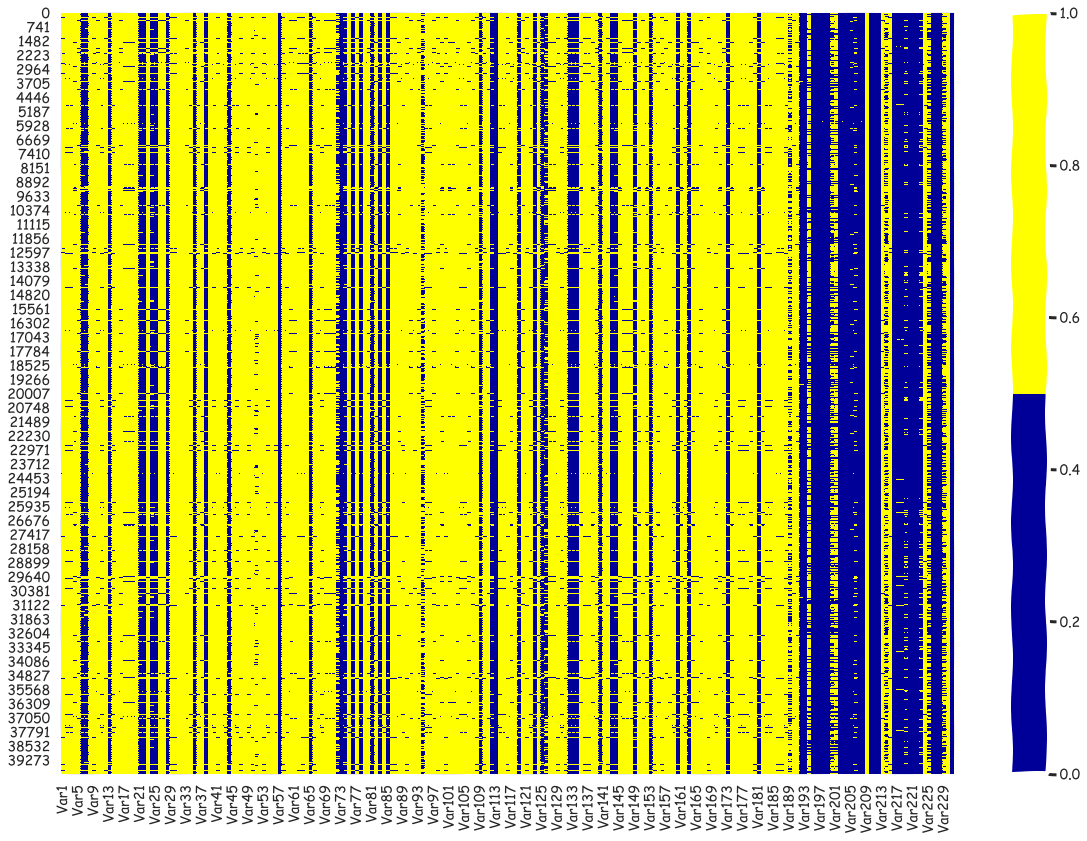

In [826]:
null_map(data)

В данных очень много практически пустых стобцов, их нужно удалить

Теперь напишем функцию первичного отбора и классификации признаков для дальнейшего  подбора оптимальной доли nan для удалении, а также по количеству уникальных значений

In [4]:
def feat_classif_clean_nan(data,prop_nan=0.3,len_uniq_num_min=20,len_uniq_min=2):
    
    #Функция первичного отбора (по NaN) и классификации признаков (категориальные или числовые),
    #можем менять допустимую долю NaN - prop_nan, а также пороговые количества уникальных значений
    #Возвращает списки с названиями столбцов
    
    #Обработка числовых признаков
    data_float = data.select_dtypes(include = ['float64'],).copy()
    
    cols_float_cat = []
    cols_float_num = []
    for col in data_float.columns:
        # Удаляем рассмотрения признаки,где доля nan больше prop_nan
        if data[col].dropna().shape[0]/data[col].shape[0] > 1-prop_nan:
            len_unique = np.unique(data[col].dropna()).shape[0]    
            if len_unique <= len_uniq_num_min:#порог для отнесения числового признака к категориальным                
                if len_unique >= len_uniq_min:
                    cols_float_cat.append(col)                            
            else:
                cols_float_num.append(col) 
        
            
    #Обработка нечисловых признаков
    data_not_num = data.select_dtypes(include=['object']).copy()

    cols_cat=[]
    for col in data_not_num.columns.tolist():
        # Удаляем из рассмотрения признаки,где доля nan  больше prop_nan
        if data[col].dropna().shape[0]/data[col].shape[0] > 1-prop_nan:
            len_unique = np.unique(data[col].dropna()).shape[0]
            if len_unique >= len_uniq_min:
                cols_cat.append(col)         
                
    num_columns = cols_float_num+['Var73'] #числовые признаки
    cat_columns = cols_cat+cols_float_cat #категориальные признаки
    
    return num_columns,cat_columns 

Напишем дополнительные функции для первичного отбора признаков

In [5]:
def fe_cat_clean_too_high_cardinality(data,cat_columns,max_prop_unique=1):    
    #Удаляем неинформативные признаки (слишком много категорий, 
    # доля уникальных из заполненных приближается к max_prop_unique)
    #Возвращает список с названиями столбцов    
    cat_features = data[cat_columns].copy()
    cat_columns_new = []  
    
    for col in cat_columns:        
        level_counts = cat_features[col].value_counts()        
        #Проверяем условие не слишком большого числа категорий (доля от количества объектов - max_prop_unique)
        if level_counts.shape[0]/level_counts.sum() < max_prop_unique:
            cat_columns_new.append(col)#добавляем признак         
    
    return cat_columns_new   

In [6]:
def fe_cat_cardinality_classification(data,cat_columns,N_lim=10):
    #Классифицируем категориальные признаки по количеству категорий
     #Возвращает списки с названиями столбцов
    cat_features = data[cat_columns].copy()
    
    low_cardinality_columns = []
    high_cardinality_columns = []
    for col in cat_columns:
        if cat_features[col].unique().shape[0] < N_lim:
            low_cardinality_columns.append(col)
        else:
            high_cardinality_columns.append(col)
            
    return low_cardinality_columns, high_cardinality_columns

Воспользуемся функциями, а затем поработаем на классами преобравателей данных

In [852]:
%%time
numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=0.7)
print(len(numeric_data_columns),len(categorical_data_columns0))
categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=0.1)
print(len(categorical_data_columns))
low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=50)
print(len(low_cardinality_cat_columns),len(high_cardinality_cat_columns))

31 43
38
29 9
Wall time: 3.89 s


In [853]:
numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)
sum(numeric_data_indices)

31

In [854]:
low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)
sum(low_card_cat_data_indices)

29

In [855]:
high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
sum(high_card_cat_data_indices)

9

In [856]:
data.iloc[:,numeric_data_indices].head()

,Var6,Var13,Var21,Var22,Var24,Var25,Var28,Var38,Var57,Var73,...,Var125,Var126,Var133,Var134,Var140,Var149,Var153,Var160,Var163,Var189
0,3052.0,NaN,480.0,600.0,20.0,480.0,200.00,82752.0,2.907926,34,...,NaN,4.0,326915.0,604276.0,NaN,389396.0,2313888.0,28.0,599532.0,NaN
1,1813.0,636.0,212.0,265.0,2.0,128.0,166.56,2706120.0,5.870327,128,...,24912.0,40.0,1934460.0,349568.0,205.0,735.0,6502680.0,14.0,364182.0,276.0
2,1953.0,448.0,176.0,220.0,0.0,72.0,311.76,4698780.0,5.981628,166,...,7218.0,36.0,3148410.0,1086210.0,400.0,0.0,10569040.0,18.0,0.0,NaN
3,1533.0,4.0,332.0,415.0,0.0,144.0,220.08,864384.0,5.108097,30,...,693.0,NaN,7066700.0,650390.0,5.0,0.0,9676200.0,108.0,253284.0,NaN
4,686.0,0.0,160.0,200.0,2.0,48.0,278.00,4364880.0,0.650716,32,...,468.0,-28.0,3794460.0,642816.0,225.0,554414.0,10535200.0,24.0,2851284.0,NaN


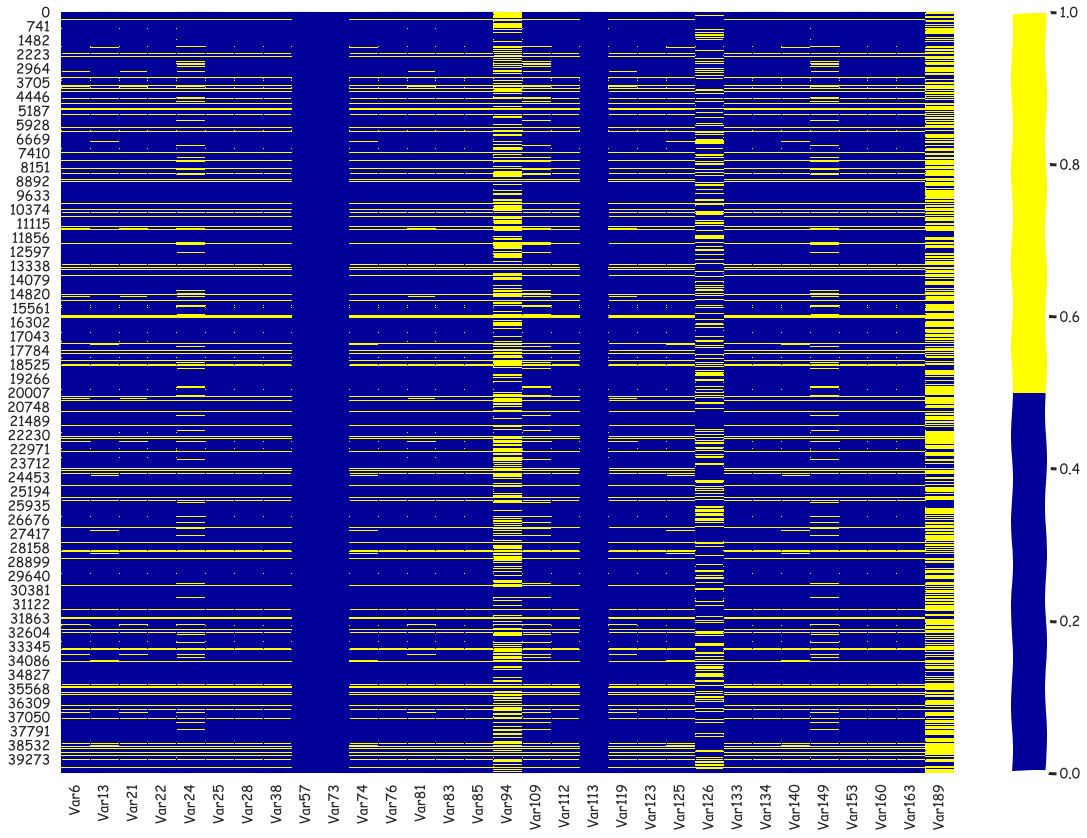

In [823]:
null_map(data.iloc[:,numeric_data_indices])

In [839]:
data.iloc[:,low_card_cat_data_indices].head()

,Var7,Var35,Var44,Var65,Var72,Var78,Var132,Var143,Var144,Var173,...,Var210,Var211,Var218,Var219,Var221,Var223,Var225,Var226,Var227,Var229
0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,9.0,0.0,...,uKAI,L84s,cJvF,FzaX,Al6ZaUT,LM8l689qOp,NaN,fKCe,02N6s8f,NaN
1,7.0,0.0,0.0,27.0,3.0,0.0,0.0,0.0,18.0,0.0,...,uKAI,L84s,cJvF,FzaX,oslk,LM8l689qOp,ELof,xb3V,RAYp,mj86
2,7.0,0.0,0.0,18.0,3.0,0.0,0.0,0.0,27.0,0.0,...,uKAI,L84s,UYBR,FzaX,zCkv,LM8l689qOp,NaN,FSa2,ZI9m,mj86
3,7.0,5.0,0.0,9.0,NaN,0.0,8.0,0.0,0.0,0.0,...,uKAI,L84s,cJvF,FzaX,oslk,LM8l689qOp,NaN,xb3V,RAYp,NaN
4,7.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,9.0,0.0,...,uKAI,L84s,cJvF,FzaX,oslk,LM8l689qOp,NaN,WqMG,RAYp,NaN


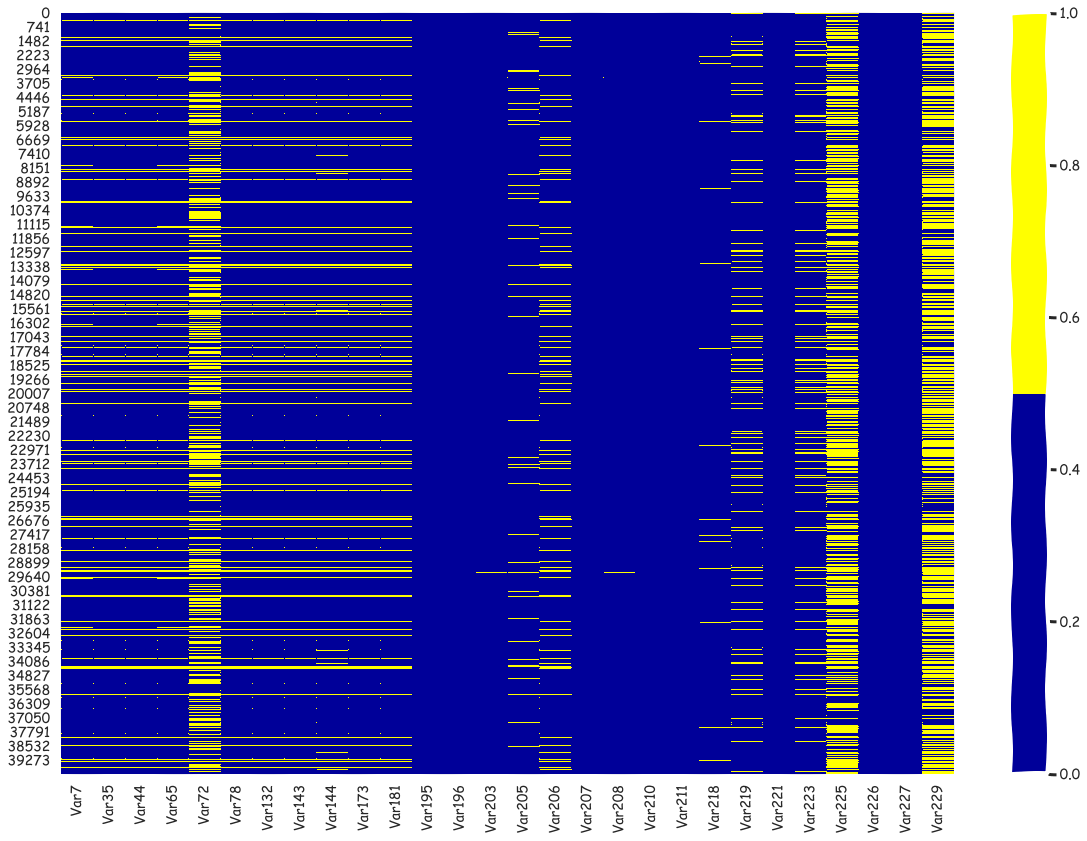

In [824]:
null_map(data.iloc[:,low_card_cat_data_indices])

In [840]:
data.iloc[:,high_card_cat_data_indices].head()

,Var192,Var193,Var197,Var198,Var199,Var202,Var204,Var212,Var216,Var217,Var220,Var222,Var228
0,NESt0G8EIb,AERks4l,0LaQ,UaKK0yW,I1sFbv_0IT,EkHG,k13i,JBfYVit4g8,TDctq2l,KmRo,hLKtJ9p,vr93T2a,xwM2aC7IdeMC0
1,P1WvyxLp3Z,2Knk1KF,YFAj,Bnunsla,o64y9zI,JDd6,FbIm,XfqtO3UdzaXh_,XTbqizz,qMoY,hN8KpA1,6hQ9lNX,55YFVY9
2,FoxgUHSK8h,LrdZy8QqgUfkVShG,TyGl,fhk21Ss,nQUveAzAF7,dnwD,mTeA,4kVnq_T26xq1p,pMWBUmQ,qLXr,4UxGlow,catzS2D,ib5G6X1eUxUn6
3,vNEvyxLp3Z,RO12,0Xwj,uoZk2Zj,LWyxgtXeJL,CwmB,vzJD,NhsEn4L,kZJtVhC,JC0e,ylCK5YS,e4lqvY0,F2FyR07IdsN7I
4,4e7gUH7IEC,RO12,vSNn,kugYdIL,ZIXKpoNpqq,625Z,m_h1,NhsEn4L,NGZXfGp,064o,PYpzAu9,MAz3HNj,F2FyR07IdsN7I


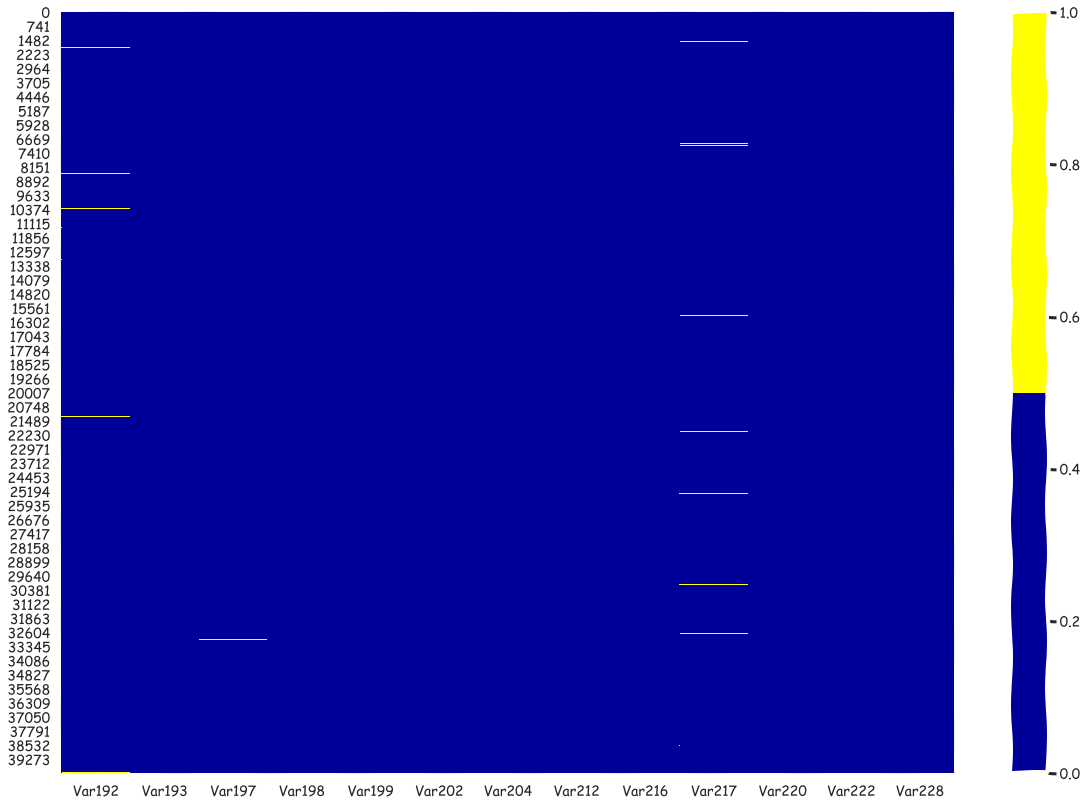

In [825]:
null_map(data.iloc[:,high_card_cat_data_indices])

Видно, что в данных не очень много пропусков, ненужные признаки удаляются. Теперь создадим класс, который объединяет редкие категории и заполнят пропуски для категориальных признаков

In [892]:
class MyCatMergerNaInputer(BaseEstimator, TransformerMixin):
    
    
    def __init__(self,occurrence_med_prop = 0.2,fill_value='NaN'):
        self.fill_value = fill_value
        self.var_cat_dict = {}
        self.occurrence_med_prop = occurrence_med_prop
        
        
    def fit(self,X,y=None):
        
        df = pd.DataFrame(X)
        df = df.fillna(self.fill_value)
        df = pd.DataFrame(df,dtype=str)
        
        for col in df.columns:
            level_counts = df[col].value_counts()
            lvl_c_median_norm = level_counts/level_counts.median()
            small_cat_list = lvl_c_median_norm[lvl_c_median_norm < self.occurrence_med_prop].index
            self.var_cat_dict[col] = small_cat_list   
       
        return self
    
    
    def transform(self,X,y=None):
        
        df = pd.DataFrame(X)
        df = df.fillna(self.fill_value)
        df = pd.DataFrame(df,dtype=str)
        
        for col in df.columns:
            df[col] = df[col].apply(lambda x: f'{col}_other_cat' if x in self.var_cat_dict[col] else x)
            
        return df.values
    
        

Зададим для начала преобразователи данных для разных типов признаков

In [858]:
numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = 0.05,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = 0.05,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()

Создадим преобразователь признаков

In [859]:
def transformation(low_level_transformers,indices_lists):
    [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer] = low_level_transformers
    [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices] = indices_lists
    return pipeline.FeatureUnion(transformer_list =[
    #numeric
    ('numeric_features_processing', pipeline.Pipeline(steps = [
    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
    ('fill_nan',numeric_imputer),
    ('scaling', numeric_scaler)            
                        ])),
    #categorical
    ('cat_features_processing', pipeline.FeatureUnion(transformer_list =[
        #number of categories < N_lim
        ('low_cardinality_transformation', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, low_card_cat_data_indices])),
                ('fill_nan',cat_imputer1 ),
                ('low_cardinality_cat_transformer', low_cardinality_cat_transformer)            
                        ])),
        #number of categories >= N_lim
        ('high_cardinality_transformation', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, high_card_cat_data_indices])),
                ('fill_nan',cat_imputer2 ),
                ('high_cardinality_cat_transformer', high_cardinality_cat_transformer)            
                        ]))
    ]))        
       
])

In [860]:
transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

transformer = transformation(transformers,indices_lists)

Воспользуемся трансформером и получим обучающую тестовую выборки для проверки бейзлайна (для простоты - первые 30000 объектов в обучающей, остальные 10000 - в тестовой)

In [864]:
transformer.fit(data.iloc[:30000].values,data['target'].iloc[:30000].values)
data_transformed_train = transformer.transform(data.iloc[:30000].values)
data_transformed_test = transformer.transform(data.iloc[30000:].values)

In [868]:
data_transformed_train

<30000x407 sparse matrix of type '<class 'numpy.float64'>'
	with 2557036 stored elements in Compressed Sparse Row format>

Посмотрим на преобразованные данные

In [869]:
pd.DataFrame(data_transformed_train.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,397,398,399,400,401,402,403,404,405,406
0,3052.0,1252.901845,480.0,600.0,20.0,480.0,200.00,82752.0,2.907926,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1813.0,636.000000,212.0,265.0,2.0,128.0,166.56,2706120.0,5.870327,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1953.0,448.000000,176.0,220.0,0.0,72.0,311.76,4698780.0,5.981628,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1533.0,4.000000,332.0,415.0,0.0,144.0,220.08,864384.0,5.108097,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,686.0,0.000000,160.0,200.0,2.0,48.0,278.00,4364880.0,0.650716,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [870]:
pd.DataFrame(data_transformed_test.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,397,398,399,400,401,402,403,404,405,406
0,651.0,8.0,80.0,100.0,6.0,8.0,313.44,822408.0,6.079684,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1442.0,0.0,448.0,560.0,14.0,72.0,269.92,7823640.0,1.788934,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,595.0,1784.0,132.0,165.0,0.0,104.0,253.52,4535178.0,6.154881,108.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1323.0,972.0,316.0,395.0,8.0,208.0,143.12,0.0,0.243965,56.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,588.0,1752.0,16.0,20.0,0.0,0.0,276.00,0.0,0.224311,120.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


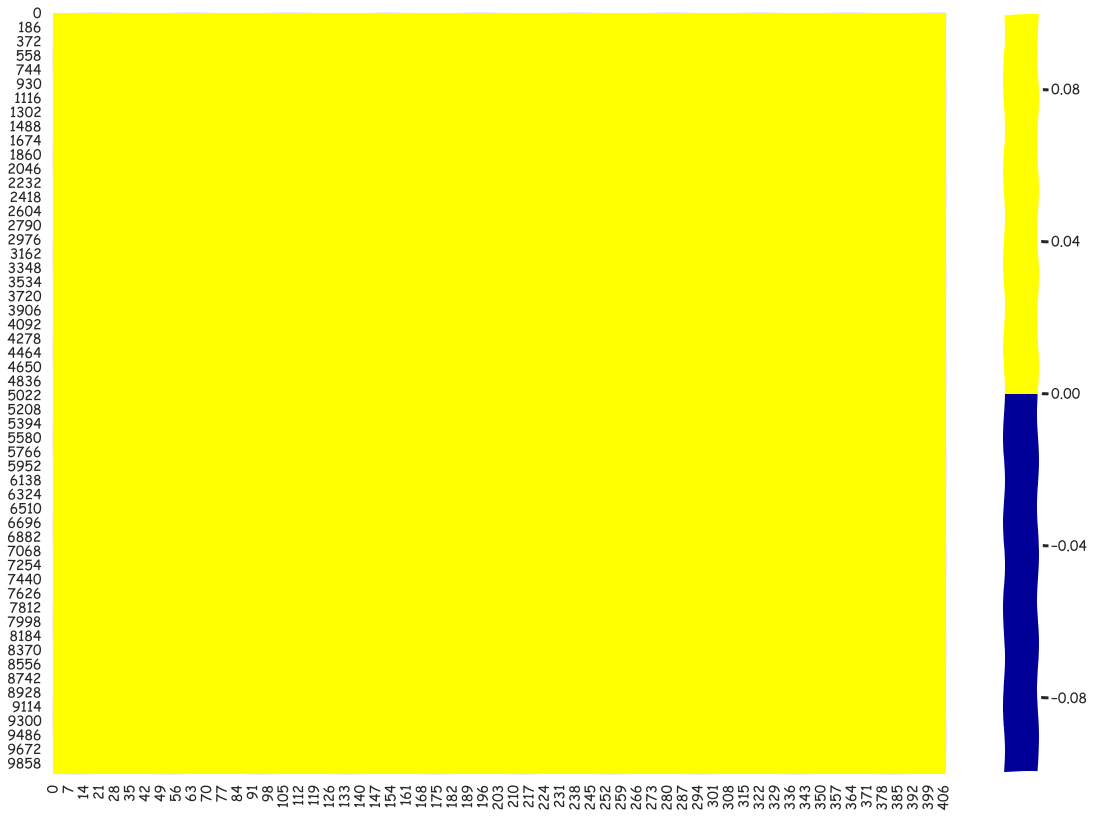

In [871]:
null_map(pd.DataFrame(data_transformed_test.todense()))

Видно, что после преобразования признаков несколько больше (one hot и binary кодировщики сыграли свою роль), при этом картинка выше показывает, что пропусков больше нет.

Зададим классификатор в первом приближении, а затем создадим класс для пайплайна, который на вход будет получать данные, а на выходе будем иметь предсказанные метки и вероятности

In [874]:
classifier = xgb.XGBClassifier()

Попробуем обучить и посмотреть на качество по ранее полученным данным.

In [875]:
%%time
classifier.fit(data_transformed_train,labels.iloc[:30000])
pred00 = classifier.predict(data_transformed_test)
print(classification_report(labels.iloc[30000:],pred00))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.50      0.01      0.01       733

    accuracy                           0.93     10000
   macro avg       0.71      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

Wall time: 31.2 s


Теперь обернем все в пайплайн

In [893]:
class Estimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, transformer,classifier):
        self.transformer = transformer
        self.classifier = classifier

    def fit(self, X, y):
        self.transformer.fit(X,y)
        X_tr = self.transformer.transform(X)         
        self.classifier.fit(X_tr,y)
        return self.classifier

    def predict(self, X):
        X_tr = self.transformer.transform(X)        
        return self.classifier.predict(X_tr)
    
    def predict_proba(self,X):
        X_tr = self.transformer.transform(X)        
        return self.classifier.predict_proba(X_tr)
    


Проверим модель

In [786]:
est = Estimator(transformer,classifier)
est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
prb = est.predict_proba(data.iloc[30000:].values)

In [787]:
roc_auc_score(labels.iloc[30000:].values,prb[:,1])

0.7538764714117824

In [788]:
average_precision_score(labels.iloc[30000:].values,prb[:,1])

0.21670972843305653

In [789]:
%%time
prb0 = est.predict(data.iloc[30000:].values)
print(classification_report(data['target'].iloc[30000:],prb0))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.50      0.01      0.01       733

    accuracy                           0.93     10000
   macro avg       0.71      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

Wall time: 1.91 s


In [790]:
def pr_plot(y_true,probs, thrshs):
    #Функция для визуализации результатов
    
    precisions=[]
    recalls=[]
    thrshs=thrshs
    for threshold in thrshs:
        y_pred = [1 if prob > threshold else -1 for prob in probs[:,1]]
        precisions.append(precision_score(y_true,y_pred))
        recalls.append(recall_score(y_true,y_pred))

    with plt.xkcd():
        plt.plot(thrshs, precisions,label='precision');    
        plt.plot(thrshs, recalls,label='recall');   
        plt.xlabel('threshold')
        plt.legend()
        plt.title('Зависимость значений метрик от порога')
        plt.grid()
        plt.ylabel('metric');


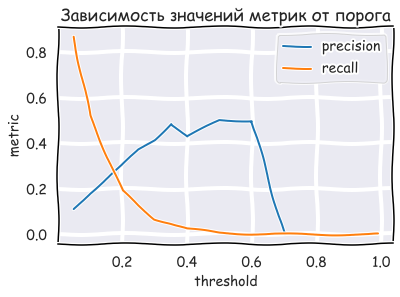

In [791]:
pr_plot(data['target'].iloc[30000:],prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

Подберем параметры преобразователей данных

In [795]:
%%time
[prop_nan,max_prop_unique,N_lim] = [0.7,0.3,50]

for occurrence_med_prop in [0.05,0.1,0.13,0.16,0.18,0.21,0.24,0.3]:

    numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


    categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
    low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)


    low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
    high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
                                                                        
                                                                        
    numeric_imputer = impute.SimpleImputer()
    numeric_scaler = None
    cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
    high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
    transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
    indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

    transformer = transformation(transformers,indices_lists)
    classifier = xgb.XGBClassifier()
                                                                      
    est = Estimator(transformer,classifier)
    est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
    prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
    print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
    print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
    print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
    prb0 = est.predict(data.iloc[30000:].values)
    print(classification_report(data['target'].iloc[30000:],prb0))  
    print('------------------')
    print('------------------')
                                                                        

Parameters:[0.7, 0.3, 50, 0.05]
ROC AUC: 0.7547351859956944
PRC AUC: 0.2144061493601901
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.58      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.76      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.3, 50, 0.1]
ROC AUC: 0.751265952577697
PRC AUC: 0.2152337710201777
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.64      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.78      0.50      0.49     10000
weighted avg       0.91      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.3, 50, 0.13]
ROC AUC: 0.7524026121529387
PRC AUC: 0.2149001583671415
        

In [796]:
%%time
[max_prop_unique,N_lim,occurrence_med_prop] = [0.3,50,0.1]

for prop_nan in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:

    numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


    categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
    low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)


    low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
    high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
                                                                        
                                                                        
    numeric_imputer = impute.SimpleImputer()
    numeric_scaler = None
    cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
    high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
    transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
    indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

    transformer = transformation(transformers,indices_lists)
    classifier = xgb.XGBClassifier()
                                                                      
    est = Estimator(transformer,classifier)
    est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
    prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
    print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
    print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
    print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
    prb0 = est.predict(data.iloc[30000:].values)
    print(classification_report(data['target'].iloc[30000:],prb0))  
    print('------------------')
    print('------------------')
                                  

Parameters:[0.3, 0.3, 50, 0.1]
ROC AUC: 0.7493059840172798
PRC AUC: 0.2104796925986272
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.50      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.71      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Parameters:[0.4, 0.3, 50, 0.1]
ROC AUC: 0.748524484554105
PRC AUC: 0.20992642357932637
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.60      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.76      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Parameters:[0.5, 0.3, 50, 0.1]
ROC AUC: 0.7491614172897978
PRC AUC: 0.21149870677979318
        

In [798]:
%%time
[prop_nan,N_lim,occurrence_med_prop] = [0.7,50,0.1]

for max_prop_unique in [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6]:

    numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


    categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
    low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)


    low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
    high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
                                                                        
                                                                        
    numeric_imputer = impute.SimpleImputer()
    numeric_scaler = None
    cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
    high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
    transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
    indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

    transformer = transformation(transformers,indices_lists)
    classifier = xgb.XGBClassifier()
                                                                      
    est = Estimator(transformer,classifier)
    est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
    prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
    print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
    print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
    print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
    prb0 = est.predict(data.iloc[30000:].values)
    print(classification_report(data['target'].iloc[30000:],prb0))  
    print('------------------')
    print('------------------')
                                  

Parameters:[0.7, 0.1, 50, 0.1]
ROC AUC: 0.7532692764346959
PRC AUC: 0.21730233432412321
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.60      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.76      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.2, 50, 0.1]
ROC AUC: 0.751265952577697
PRC AUC: 0.2152337710201777
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.64      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.78      0.50      0.49     10000
weighted avg       0.91      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.25, 50, 0.1]
ROC AUC: 0.751265952577697
PRC AUC: 0.2152337710201777
         

In [799]:
%%time
[prop_nan,max_prop_unique,occurrence_med_prop] = [0.7,0.5,0.1]

for N_lim in [10,15,20,25,30,35,40,45,50,60,70,100,120,200]:

    numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


    categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
    low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)


    low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
    high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
                                                                        
                                                                        
    numeric_imputer = impute.SimpleImputer()
    numeric_scaler = None
    cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
    low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
    high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
    transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
    indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

    transformer = transformation(transformers,indices_lists)
    classifier = xgb.XGBClassifier()
                                                                      
    est = Estimator(transformer,classifier)
    est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
    prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
    print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
    print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
    print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
    prb0 = est.predict(data.iloc[30000:].values)
    print(classification_report(data['target'].iloc[30000:],prb0))  
    print('------------------')
    print('------------------')

Parameters:[0.7, 0.5, 10, 0.1]
ROC AUC: 0.7523405603447578
PRC AUC: 0.2155946000626474
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.54      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.73      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.5, 15, 0.1]
ROC AUC: 0.7530307118910256
PRC AUC: 0.21537625582366804
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.45      0.01      0.01       733

    accuracy                           0.93     10000
   macro avg       0.69      0.50      0.49     10000
weighted avg       0.89      0.93      0.89     10000

------------------
------------------
Parameters:[0.7, 0.5, 20, 0.1]
ROC AUC: 0.7544160939571843
PRC AUC: 0.21516208943090082
       

Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.7522054890897022
PRC AUC: 0.21657339910499507
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.70      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.81      0.50      0.49     10000
weighted avg       0.91      0.93      0.89     10000

------------------
------------------


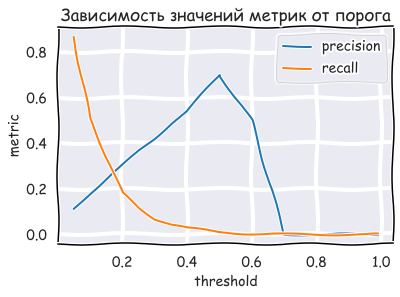

In [803]:
#Пока лучшие параметры 
[prop_nan,max_prop_unique,N_lim,occurrence_med_prop] = [0.7, 0.5, 30, 0.1]


numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)


low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
                                                                        
                                                                        
numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]
indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]

transformer = transformation(transformers,indices_lists)
classifier = xgb.XGBClassifier()
                                                                      
est = Estimator(transformer,classifier)
est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
prb0 = est.predict(data.iloc[30000:].values)
print(classification_report(data['target'].iloc[30000:],prb0))  
print('------------------')
print('------------------')

pr_plot(data['target'].iloc[30000:],prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

Функция для подготовки данных

In [828]:
def data_preprocessor(data,params):
    #return indices fo each category
    
    data=data.copy()
    [prop_nan,max_prop_unique,N_lim] = params
    
    
    numeric_data_columns,categorical_data_columns0 = feat_classif_clean_nan(data,prop_nan=prop_nan)
    numeric_data_indices = np.array([(column in numeric_data_columns) for column in data.columns], dtype = bool)


    categorical_data_columns = fe_cat_clean_too_high_cardinality(data,categorical_data_columns0,max_prop_unique=max_prop_unique)
    
    low_cardinality_cat_columns ,high_cardinality_cat_columns = fe_cat_cardinality_classification(data,\
                                                                                              categorical_data_columns,N_lim=N_lim)
    low_card_cat_data_indices = np.array([(column in low_cardinality_cat_columns) for column in data.columns], dtype = bool)
    high_card_cat_data_indices = np.array([(column in high_cardinality_cat_columns) for column in data.columns], dtype = bool)
    
    
    indices_lists = [numeric_data_indices,low_card_cat_data_indices,high_card_cat_data_indices]
    return indices_lists

Применим все, что имеем

Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.7522054890897022
PRC AUC: 0.21657339910499507
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.70      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.81      0.50      0.49     10000
weighted avg       0.91      0.93      0.89     10000

------------------
------------------
Wall time: 32 s


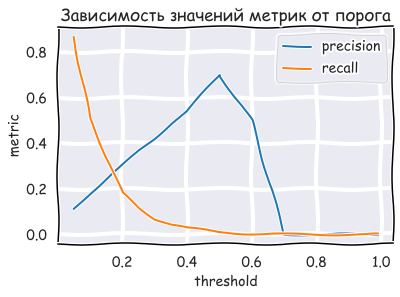

In [837]:
%%time
indices_lists = data_preprocessor(data,params=[0.7, 0.5, 30])
occurrence_med_prop = 0.1

numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
low_level_transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]

transformer = transformation(low_level_transformers,indices_lists)
classifier = xgb.XGBClassifier()
                                                                      
est = Estimator(transformer,classifier)
est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
pred = est.predict(data.iloc[30000:].values)
print(classification_report(data['target'].iloc[30000:],pred))  
print('------------------')
print('------------------')

pr_plot(data['target'].iloc[30000:],prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])


Видно, что лучше работать в зоне малых порогов, тогда имеем более высокие значения precision и recall.


Теперь попробуем предварительно удалить  коррелирующие признаки (см. самое начало)

In [816]:
data1=data.copy()


Коррелирующие признаки (104, 105),(129, 66, 9),(131 и 50), (177 и 114), (23,107,157 и 166), (77 и 12), (24,25) и (136,154)

In [817]:
data_new = data.drop(columns = ['Var105','Var66','Var9','Var50','Var114','Var23','Var157','Var12','Var25','Var154'])
data_new.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var10,Var11,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,target
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.7527550487574107
PRC AUC: 0.2165979225811926
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.60      0.01      0.02       733

    accuracy                           0.93     10000
   macro avg       0.76      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Wall time: 36.9 s


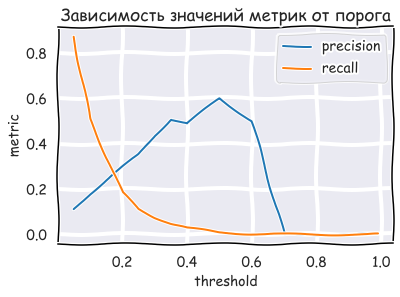

In [830]:
%%time
indices_lists = data_preprocessor(data_new,params=[0.7, 0.5, 30])
occurrence_med_prop = 0.1

numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
low_level_transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]

transformer = transformation(low_level_transformers,indices_lists)
classifier = xgb.XGBClassifier()
                                                                      
est = Estimator(transformer,classifier)
est.fit(data_new.iloc[:30000].values,labels.iloc[:30000].values)
prb = est.predict_proba(data_new.iloc[30000:].values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
pred = est.predict(data_new.iloc[30000:].values)
print(classification_report(data['target'].iloc[30000:],pred))  
print('------------------')
print('------------------')

pr_plot(data['target'].iloc[30000:],prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

Значения метрик несколько ухудшились, значит, среди признаков были значимые, а их корреляция не была столь значительна.

Посмотрим на значения метрик для случая отсутствия предобработки, только заполняем пропуски.

Parameters:[0.7, 0.5, 30, 0]
ROC AUC: 0.7538292148745913
PRC AUC: 0.21878749713320159
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9267
           1       0.50      0.00      0.01       733

    accuracy                           0.93     10000
   macro avg       0.71      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000

------------------
------------------
Wall time: 1min 14s


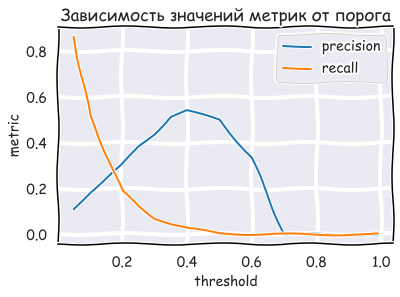

In [835]:
%%time
#[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]=[1,1,400,0]
indices_lists = data_preprocessor(data,params=[1,1,30])
occurrence_med_prop=0

numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
low_level_transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]

transformer = transformation(low_level_transformers,indices_lists)
classifier = xgb.XGBClassifier()
                                                                      
est = Estimator(transformer,classifier)
est.fit(data.iloc[:30000].values,labels.iloc[:30000].values)
prb = est.predict_proba(data.iloc[30000:].values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels.iloc[30000:].values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels.iloc[30000:].values,prb[:,1])}')   
                                                                        
pred = est.predict(data.iloc[30000:].values)
print(classification_report(data['target'].iloc[30000:],pred))  
print('------------------')
print('------------------')

pr_plot(data['target'].iloc[30000:],prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

Видно, что предобработка ускоряет работу алгоритмов и несколько улучшает качество при пороге 0.5, при этом практически не влияет на метрики AUC ROC и AUC PRC. 

**Итак, при алгоритме классификации по умолчанию и подобранных параметрах предобработки при пороге 0.5 удается выявить 1 % класса "Отток" с точностью срабатывания 70 %. При пороге 0.2 обе метрики приближаются к 30 %. Также отметим, что предобработка существенно улучшает скоростные характеристики алгоритмов, что немаловажно при дальнейшем подборе параметров алгоритмов на сетке, поскольку у меня довольно скромный по характеристикам компьютер**

## 2. Подбор модели для бейзлайн решения.

Далее будем работать на тренировочных данных, полученным аналогично предыдущей неделе.

In [880]:
feats_train,feats_val,labels_train,labels_val = train_test_split(features,labels, test_size = 0.3,\
                                                                   shuffle=True,random_state=42,\
                                                                   stratify = labels)

Посмотрим на данные

In [883]:
feats_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
6892,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,oslk,76DJixu,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
34821,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,oslk,G9maF5M,NaN,NaN,NaN,w_Ub,RAYp,F2FyR07IdsN7I,NaN,NaN
34190,NaN,NaN,NaN,NaN,NaN,98.0,0.0,NaN,NaN,NaN,...,oslk,DQ3u3MC,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
24541,NaN,NaN,NaN,NaN,NaN,938.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,jySVZNlOJy,NaN,ELof,WqMG,ZI9m,TCU50_Yjmm6GIBZ0lL_,mj86,NaN
31483,NaN,NaN,NaN,NaN,NaN,602.0,7.0,NaN,NaN,NaN,...,oslk,nRgz4Af,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN


In [889]:
labels_train.head()

,target
6892,-1
34821,-1
34190,-1
24541,-1
31483,1


Предобработаем данные

In [884]:
%%time
indices_lists = data_preprocessor(feats_train,params=[0.7, 0.5, 30])


Wall time: 2.94 s


In [894]:
occurrence_med_prop = 0.1

numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
low_level_transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]

transformer = transformation(low_level_transformers,indices_lists)

Зададим классификаторы для подбора на кроссвалидации

In [907]:
classifier1 = xgb.XGBClassifier(random_state=42)
classifier2 = RandomForestClassifier()
classifier3= SGDClassifier(loss='log')

In [888]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [895]:
for classifier in [classifier1, classifier2, classifier3]:
    estimator = Estimator(transformer,classifier)
    print('{}'.format(classifier))
    print()
    print('Mean AUC ROC:')
    ROC_AUC_scores = cross_val_score(estimator,feats_train.values,labels_train.values,\
                                         cv=skf,n_jobs=-1,scoring='roc_auc')
    print(ROC_AUC_scores.mean())
    print('Standart deviation of AUC ROC:')
    print(ROC_AUC_scores.std())
    print('--------------')
    print('--------------')    
     

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Mean AUC ROC:
0.7362417174331867
Standart deviation of AUC ROC:
0.008283728683580311
--------------
--------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimat

Видно, что с данной задачей лучше всего справляется градиентный бустинг. Подтвердим данный факт, разделив уже тренировочные данные на обучение и валидацию, а потов воспользовавшись дополнительными метриками качества.

In [897]:

feats_train2,feats_val2,labels_train2,labels_val2 = train_test_split(feats_train,labels_train, test_size = 0.25,\
                                                                     shuffle=True,random_state=42,\
                                                                   stratify = labels_train)

In [898]:
%%time
indices_lists = data_preprocessor(feats_train2,params=[0.7, 0.5, 30])
occurrence_med_prop = 0.1

numeric_imputer = impute.SimpleImputer()
numeric_scaler = None
cat_imputer1 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
cat_imputer2 =  MyCatMergerNaInputer(occurrence_med_prop = occurrence_med_prop,fill_value='Hi')
low_cardinality_cat_transformer=preprocessing.OneHotEncoder(handle_unknown = 'ignore')
high_cardinality_cat_transformer=BinaryEncoder()  
                                                                        
                                                                        
low_level_transformers = [numeric_imputer,numeric_scaler,cat_imputer1,cat_imputer2,\
                low_cardinality_cat_transformer,high_cardinality_cat_transformer]

transformer = transformation(low_level_transformers,indices_lists)


Wall time: 2.53 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.7323511453954737
PRC AUC: 0.1973167845299197
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      6479
           1       0.35      0.01      0.03       521

    accuracy                           0.92      7000
   macro avg       0.64      0.51      0.49      7000
weighted avg       0.88      0.92      0.89      7000

------------------
------------------
Wall time: 38.8 s


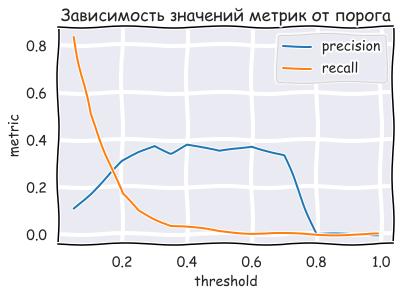

In [903]:
%%time
print(classifier1)                                                                     
est = Estimator(transformer,classifier1)
est.fit(feats_train2.values,labels_train2.values)
prb = est.predict_proba(feats_val2.values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels_val2.values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels_val2.values,prb[:,1])}')   
                                                                        
pred = est.predict(feats_val2.values)
print(classification_report(labels_val2.values,pred))  
print('------------------')
print('------------------')

pr_plot(labels_val2.values,prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.6448681536895075
PRC AUC: 0.13050230838257643
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      6479
           1       0.00      0.00      0.00       521

    accuracy                           0.93      7000
   macro avg       0.46      0.50      0.48      7000
weighted avg       0.86      0.93      0.89      7000

------------------
------------------


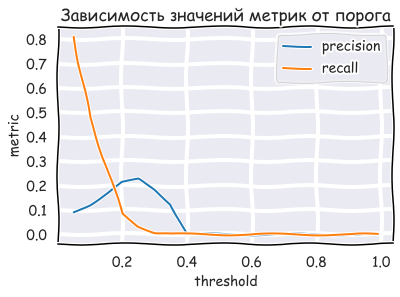

In [904]:
%%time
print(classifier2)                                                                     
est = Estimator(transformer,classifier2)
est.fit(feats_train2.values,labels_train2.values)
prb = est.predict_proba(feats_val2.values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels_val2.values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels_val2.values,prb[:,1])}')   
                                                                        
pred = est.predict(feats_val2.values)
print(classification_report(labels_val2.values,pred))  
print('------------------')
print('------------------')

pr_plot(labels_val2.values,prb,[0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Parameters:[0.7, 0.5, 30, 0.1]
ROC AUC: 0.5398779876162734
PRC AUC: 0.08078347835460938
              precision    recall  f1-score   support

          -1       0.94      0.53      0.68      6479
           1       0.09      0.55      0.15       521

    accuracy                           0.54      7000
   macro avg       0.51      0.54      0.41      7000
weighted avg       0.87      0.54      0.64      7000

------------------
------------------
Wall time: 14.2 s


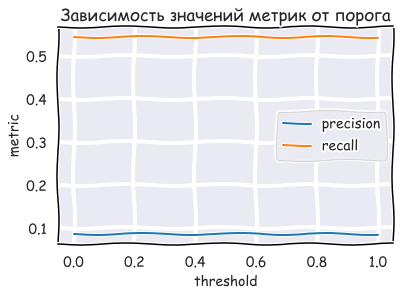

In [908]:
%%time
print(classifier3)                                                                     
est = Estimator(transformer,classifier3)
est.fit(feats_train2.values,labels_train2.values)
prb = est.predict_proba(feats_val2.values)  
                                                                        
print(f'Parameters:{[prop_nan,max_prop_unique,N_lim,occurrence_med_prop]}')                                                                   
print(f'ROC AUC: {roc_auc_score(labels_val2.values,prb[:,1])}')    
print(f'PRC AUC: {average_precision_score(labels_val2.values,prb[:,1])}')   
                                                                        
pred = est.predict(feats_val2.values)
print(classification_report(labels_val2.values,pred))  
print('------------------')
print('------------------')

pr_plot(labels_val2.values,prb,[0.0001,0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99,0.9999])

**Итак, целесообразно выбрать градиентный бустинг, поскольку по метрикам он лучше всего. К тому же, случайный лес имеет очень низкие точность и полноту (возможно, из-за one-hot-encoding?), логистическая регрессия имеет крайне низкую точность, что и сказывается на основной и вспомогательной метриках. Стоит отметить причудливую картину логистической регрессии в зависимости от порога.**